# Titanic Prediction

This notebook describes the process of developing a model to predict deaths on the Titanic, based on the input features. 

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv("./data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preliminary hypotheses
To begin with, let us perform an informal analysis on the features, and whether they are relevant. We exclude the `Survived` feature as this is our prediction target.

The `Variable` column lists the feature we are analyzing. The `Type` describes the feature. The `Segment` categorizes the feature under Human (for human attributes like age or sex) or Passenger (for attributes associated with being a passenger of the Titanic like cabin number). The `Expectation` is our guess on the importance of the feature when predicting the `survival`. The `Conclusion`, which will be added afterwards, is the actual importance as shown by our formal analysis.

| Variable   | Type                                               | Segment   | Expectation                             | Conclusion | Comments                                                     |
| ---------- | -------------------------------------------------- | --------- | --------------------------------------- | ---------- | ------------------------------------------------------------ |
| `pclass`   | The ticket class                                   | Passenger | Medium                                  |  ?         | 1 =  1st, 2 = 2nd, 3 = 3rd <br />The ticket class may have a causal effect on `survival`. It is possible there was some bias in favour of the wealthier passengers in securing lifeboat spots. This may arise from explicit discrimination against lower-class paseengers, or instead, the differences in survival rate may be attributed to, say, lower-class passengers sleeping in cabins on physically lower levels, thus, requiring them to travel further to the lifeboats or preventing them from being notified at the earliest possible moment when the titanic began to sink. <br />The exact effect is unclear and further research is needed, so the expectation is placed at Medium for simplicity. It should be emphasized that a correlation between `pclass` and `survival` **does not definitively prove** that explicit discrimination of lower-class passengers occurred, only that we cannot reject it as a hypothesis based on the observed data. |
| `ticket`   | The ticket number                                  | Passenger | Low                                     |  ?         | This needs more research. If tickets were assigned randomly, then there is likely little to no relationship with `survival`. On the other hand, if tickets were tied to a factor like cabin number, which is tied to wealth, then ticket number may influence survival based on the same explanation for `pclass`<br />From inspection of the data, there appear to be no patterns in how ticket numbers are assigned. In fact, it seems as though different companies with different ticket formats sold tickets to the Titanic, which makes it difficult to compare tickets. For simplicity, we will guess that the ticket numbers are randomly assigned and have no connection to `survival` |
| `fare`     | The passenger fare                                 | Passenger | Medium                                  |  High       | This feature is probably related to `pclass`. It may be possible to replace the `pclass` with the `fare`. |
| `cabin`    | Cabin number                                       | Passenger | Medium                                  | ?          | According to this [source](https://www.encyclopedia-titanica.org/cabins.html), this feature is probably related to `pclass`. This feature usually consists of string values consisting of 1 letter, a dash, then up to 2 numbers. It is known that cabin numbers beginning in A were in first-class, but D to F could be second- or third-class. <br />We may consider replacing this feature with `fare`, which is a numerical variable that provides a more reliable indicator of a passenger's socioeconomic status. <br />Alternatively, we can decompose the `cabin` into two features, `cabin-letter` and `cabin-number`, since `cabin` by itself does not duplicate any classes and is ill-suited for one-hot encoding. |
| `embarked` | Port of Embarkation                                | Passenger | Medium                                  |  High      | C= Cherbourg (France), Q = Queenstown (now Cobh, Ireland), S = Southhampton (England)<br />Further research is needed to justify the hypothesis that `embarked` has a causal relationship to `survival`. One possibility is that Irishmen were discriminated by Englishmen on board the Titanic and were given less priority for lifeboats. More analysis is required to establish any correlation, and it should be emphasized that any correlation found **does not definitively prove** that such discrimination occurred aboard the Titanic, only that we cannot reject it as hypothesis based on the observed data. |
| `Age`      | The age in years                                   | Human     | High                                    |  High      | It is well-known that women and children were offered lifeboats first. Therefore, age is likely a strong factor in survival. We expect that regardless of gender, lower age increases survival chance. |
| `sex`      | The sex of the passenger                           | Human     | High                                    |  High      | It is well-known that women and children were offered lifeboats first. Therefore, sex is likely a strong factor in survival. We expect that regardless of age, a woman is more likely to survive than a man. |
| `sibsp`    | The number of siblings / spouses abord the Titanic | Human     | Low/High (depending on `Age` and `Sex`) |  Medium     | This factor is likely an important factor in survival. Note that `sibsp`'s effect on `survival` might differ depending on `Age` and `sex`. <br />If `Age` is low or `sex` is female, then `sibsp` will likely be a weak factor influencing `survival`. This is because (1) women and children are prioritized, (2) family units were probably kept together to avoid distress. Therefore, a child or woman would not have to "contest" lifeboat seats with their siblings.<br />On the other hand, for an adult male, since they were not prioritized for lifeboats, then any spouses or siblings (particularly female ones) would contest the adult male, therefore, reducing his likelihood of survival. |
| `parch`    | The number of parents / children aboard the Titanic | Human     | Low/High (depending on `Age` and `Sex`) |  Medium    | This factor is likely an important factor in survival. Like with `sibsp`, this depends on `Age` and `sex`. For a woman or child, this likely did not affect survival. For an adult male, then a higher `parch` probably implies a lower survival rate. |



# Exploratory Data Analysis

We analyze the prediction target, `Survived`, in more detail. We will also attempt to discover any relationships between the explanatory features and the prediction target, through graphical summaries. A more formal, numerical analysis is performed in the Multivariate Analysis section later on.

In [7]:
# Descriptive statistics for the prediction target
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

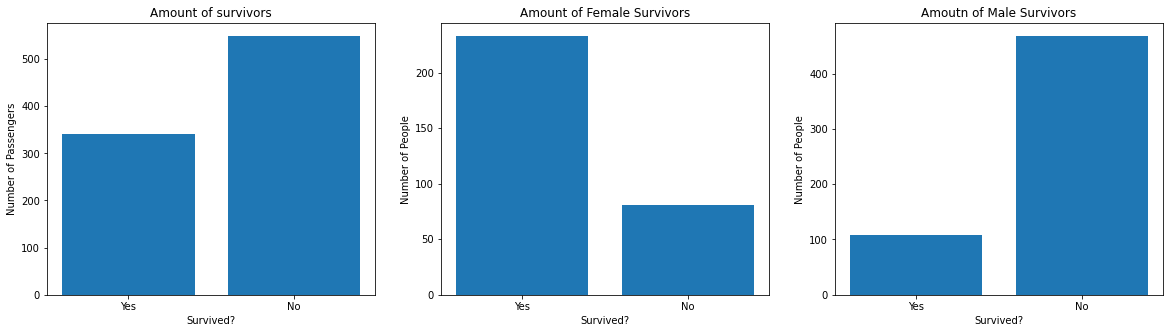

<Figure size 432x288 with 0 Axes>


Overall survival rate: 0.384
% of women who survived:  0.7420382165605095
% of men who survived: 0.18890814558058924


In [153]:
import matplotlib.pyplot as plt

women = train_data.loc[train_data.Sex == 'female']['Survived']

men = train_data.loc[train_data.Sex == 'male']['Survived']

# Plotting total survivors
tot_survived = len(train_data[train_data['Survived'] == 1])
total = len(train_data)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].bar(['Yes', 'No'],
         [tot_survived, total - tot_survived])
ax[0].set_xlabel('Survived?')
ax[0].set_ylabel('Number of Passengers')
ax[0].set_title('Amount of survivors')

# Plotting women survivors
women_survived = sum(women)
women_total = len(women)

fig = plt.figure()
ax[1].bar(['Yes', 'No'],
            [women_survived, women_total - women_survived])
ax[1].set_xlabel('Survived?')
ax[1].set_ylabel('Number of People')
ax[1].set_title('Amount of Female Survivors')

# Plotting male survivors
men_survived = sum(men)
men_total = len(men)

ax[2].bar(['Yes', 'No'],
        [men_survived, men_total - men_survived])
ax[2].set_xlabel('Survived?')
ax[2].set_ylabel('Number of People')
ax[2].set_title('Amoutn of Male Survivors')

plt.show()

rate_women = women_survived / women_total
rate_men = men_survived / men_total

print("\nOverall survival rate: {0:.3f}".format(tot_survived / total))
print("% of women who survived: ", rate_women)
print("% of men who survived:", rate_men)

Age range: [0, 80]


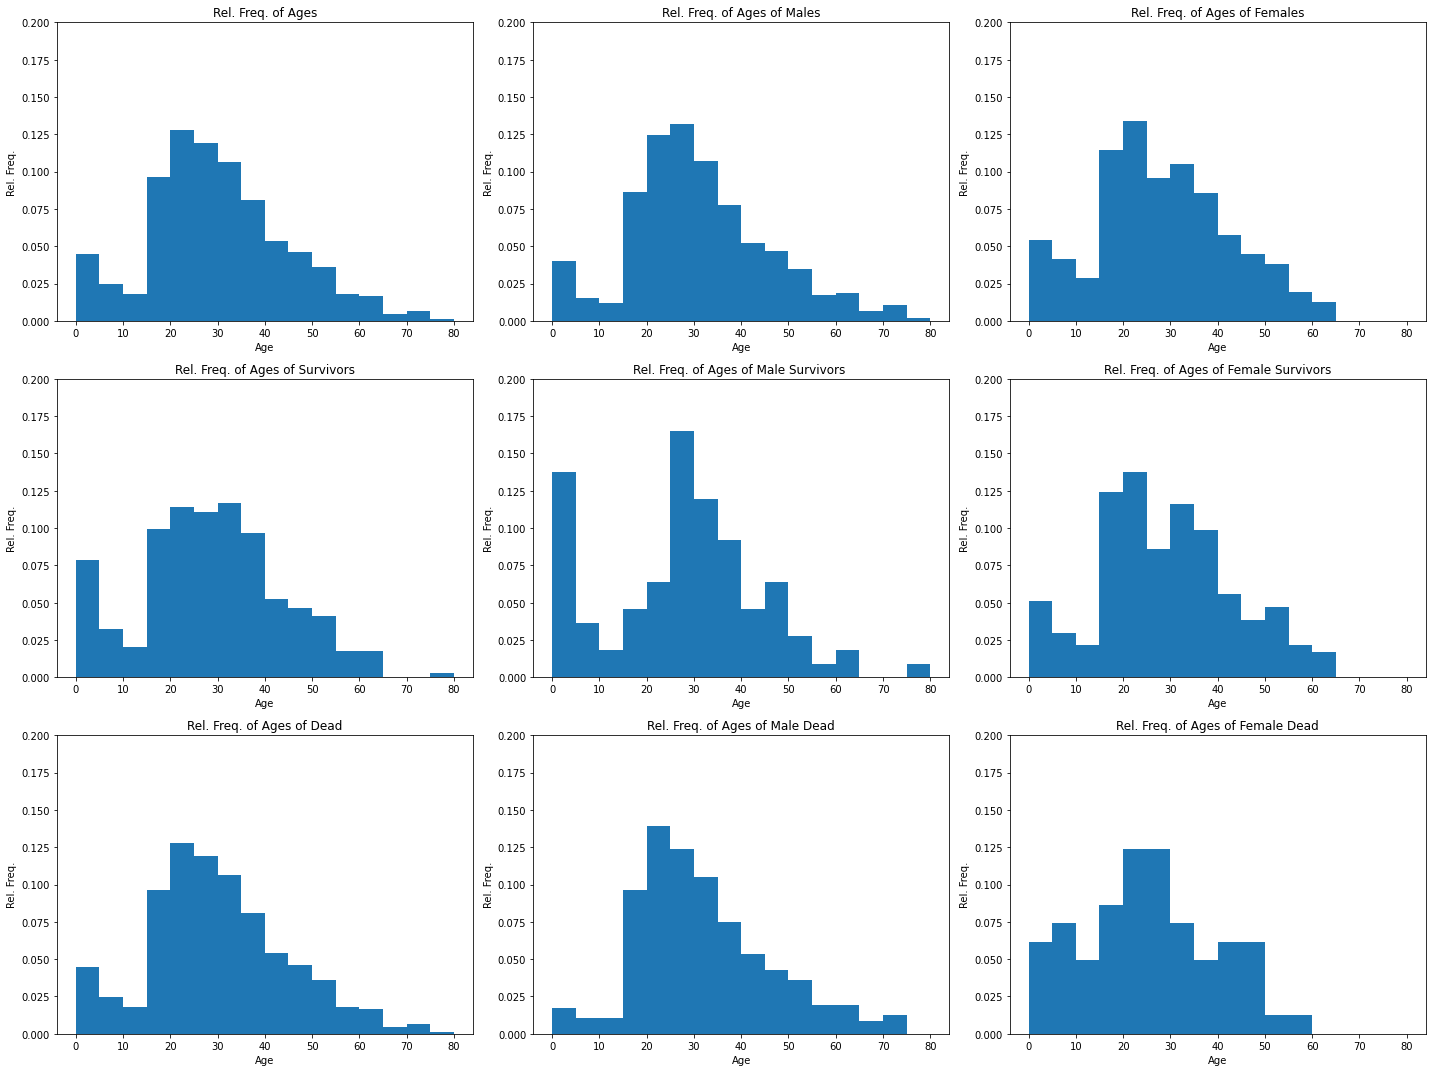

Total males: 577
Total females: 314
Total male survivors: 109
Total female survivors: 233
Total male dead: 468
Total female dead: 81


In [148]:
# Investigate any relationship between Age and Survival
max_age = max(train_data['Age'])
min_age = min(train_data['Age'])
print("Age range: [%d, %d]" % (min_age, max_age))

def plot_age_hist(ax, data):
    x = np.linspace(0, 80, num=17)
    ax.hist(data, bins=x, weights=np.zeros_like(data) + 1. / data.size)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel('Age')
    ax.set_ylabel('Rel. Freq.')


fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Histogram of survived and not survived
age_data = train_data['Age']
plot_age_hist(ax[0,0], age_data)
ax[0,0].set_title('Rel. Freq. of Ages')

male_age_data = age_data[train_data['Sex'] == 'male']
plot_age_hist(ax[0,1], male_age_data)
ax[0,1].set_title('Rel. Freq. of Ages of Males')

female_age_data = age_data[train_data['Sex'] == 'female']
plot_age_hist(ax[0,2], female_age_data)
ax[0,2].set_title('Rel. Freq. of Ages of Females')

# Histograms of those that survived
surviving_age_data = train_data[train_data['Survived'] == 1]['Age']
plot_age_hist(ax[1,0], surviving_age_data)
ax[1,0].set_title('Rel. Freq. of Ages of Survivors')

surviving_male_age_data = surviving_age_data[train_data['Sex'] == 'male']
plot_age_hist(ax[1,1], surviving_male_age_data)
ax[1,1].set_title('Rel. Freq. of Ages of Male Survivors ')

surviving_female_age_data = surviving_age_data[train_data['Sex'] == 'female']
plot_age_hist(ax[1,2], surviving_female_age_data)
ax[1,2].set_title('Rel. Freq. of Ages of Female Survivors')

# Histograms of those that did not survive
dead_age_data = train_data[train_data['Survived'] == 0]['Age']
plot_age_hist(ax[2,0], age_data)
ax[2,0].set_title('Rel. Freq. of Ages of Dead')

dead_male_age_data = dead_age_data[train_data['Sex'] == 'male']
plot_age_hist(ax[2,1], dead_male_age_data)
ax[2,1].set_title('Rel. Freq. of Ages of Male Dead')

dead_female_age_data = dead_age_data[train_data['Sex'] == 'female']
plot_age_hist(ax[2,2], dead_female_age_data)
ax[2,2].set_title('Rel. Freq. of Ages of Female Dead')

plt.tight_layout()
plt.show()

print("Total males: %d" % len(male_age_data))
print("Total females: %d" % len(female_age_data))

print("Total male survivors: %d" % len(surviving_male_age_data))
print("Total female survivors: %d" % len(surviving_female_age_data))

print("Total male dead: %d" % len(dead_male_age_data))
print("Total female dead: %d" % len(dead_female_age_data))

The eight of the nine plots generally do not seem to contradict the hypothesis that women and children were prioritized, therefore, they would likely have `Survived` as `true`. However, the bottom-right plot is puts the hypothesis into question.

In the top-left plot, we see that the age breakdown of the Titanic consisted of two groups. Children (anyone less than 15 years old) and Adults (anyone greater than 15 years old). This produces two peaks, one smaller peak with positive skew, then a larger peak to its right also with positive skew. 

In the leftmost plot in the middle row, we see that the histogram is dissimilar to the "Rel. Freq of Ages". In particular, children make up a higher proportion of the survivors compared to any other age group. Moreover, the peak corresponding to the Adults is lower, which suggests that Adults tended to have a lower probability of survival. This suggests that we cannot reject the hypothesis that lower ages causes a higher likelihood of survival.

The bottom-left plot shows the reverse behavior. The relative frequency of deaths for adults in ages `[15, 35)` appear to be higher than that of the top-left plot, whereas the relatively frequency of deaths for children is lower. Again, we cannot reject the hypothesis that lower age indicates a higher probability of survival.

In the middle column, we see similar behaviour. The bottom-middle plot shows that male adults of ages `[15, 35)` appear to have a lower probability of survival, and, the center plot shows that male children make up a significant proportion of the survivors. Interestingly, the center plot shows that males aged `[25, 30)` make a large percentage of survivors. One possibility to explain this is that the lifeboats might have needed sailors to row them, and these sailors might have been predominantly males in ages `[25, 30)`, thus, they contribute a large proportion of male survivors. Future studies should determine if the observation corresponds a sailor, so that it can control for this factor.

In the rightmost column, the middle-right plot is almost identical to the top-right plot. This indicates that as long as the passenger was female, then they had a high probability of surviving, regardless of their age. 

The bottom-right plot is the most unusual plot. Surprisingly, female children make up a significant proportion of the dead. Their relative frequency is 0.020 compared to male children, which only make up 0.005 of the dead males. Based on the hypotheses, female children should receive priority on the lifeboats and therefore have a high probability of survival. We would expect that, similarly to male children, the proportion of dead female children should be lower than the proportion of female children in the overall population. This is not the case, however. It is unclear what contributes to this deviation.

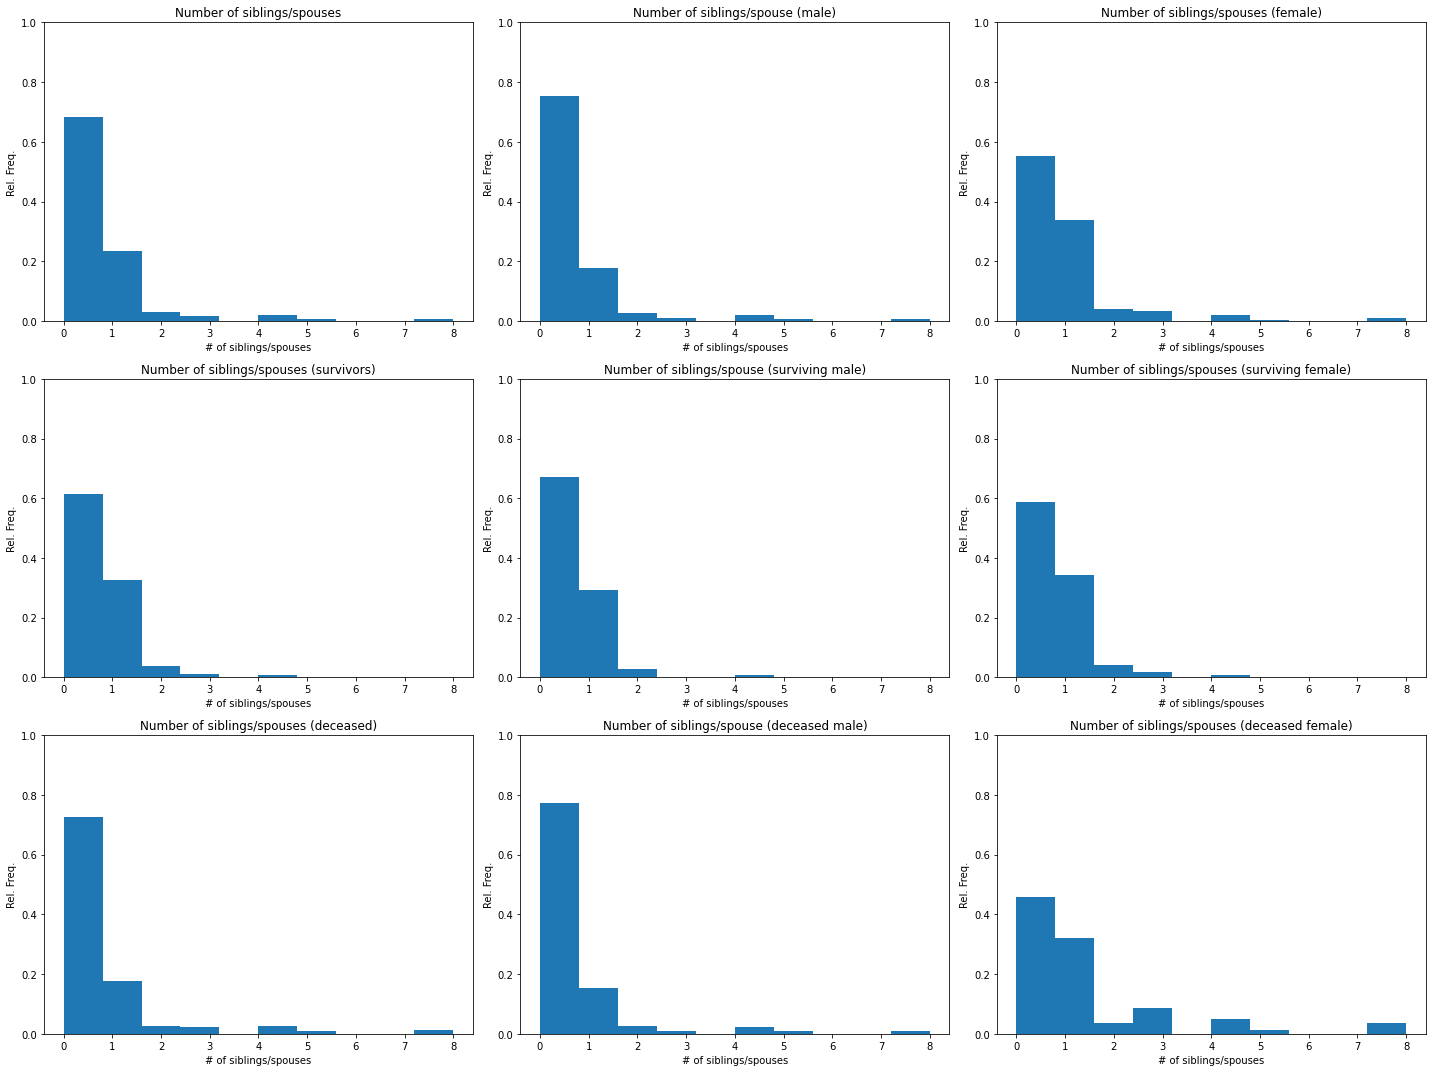

In [149]:
def plot_sibsp_hist(ax, data):
    x = np.linspace(0, 8, num=11)
    ax.hist(data, bins=x, weights=np.zeros_like(data) + 1. / data.size)
    ax.set_ylim(0, 1)
    ax.set_xlabel('# of siblings/spouses')
    ax.set_ylabel('Rel. Freq.')

total_sibsp = train_data['SibSp']
male_sibsp = total_sibsp[train_data['Sex'] == 'male']
female_sibsp = total_sibsp[train_data['Sex'] == 'female']

fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Plots of all passengers
plot_sibsp_hist(ax[0, 0], total_sibsp)
ax[0, 0].set_title("Number of siblings/spouses")

plot_sibsp_hist(ax[0, 1], male_sibsp)
ax[0, 1].set_title("Number of siblings/spouse (male)")

plot_sibsp_hist(ax[0, 2], female_sibsp)
ax[0, 2].set_title("Number of siblings/spouses (female)")

# Plots of survivors
surviving_total_sibsp = train_data[train_data['Survived'] == 1]['SibSp']
surviving_male_sibsp = surviving_total_sibsp[train_data['Sex'] == 'male']
surviving_female_sibsp = surviving_total_sibsp[train_data['Sex'] == 'female']

plot_sibsp_hist(ax[1, 0], surviving_total_sibsp)
ax[1, 0].set_title("Number of siblings/spouses (survivors)")

plot_sibsp_hist(ax[1, 1], surviving_male_sibsp)
ax[1, 1].set_title("Number of siblings/spouse (surviving male)")

plot_sibsp_hist(ax[1, 2], surviving_female_sibsp)
ax[1, 2].set_title("Number of siblings/spouses (surviving female)")

# Plots of deceased
deceased_total_sibsp = train_data[train_data['Survived'] == 0]['SibSp']
deceased_male_sibsp = deceased_total_sibsp[train_data['Sex'] == 'male']
deceased_female_sibsp = deceased_total_sibsp[train_data['Sex'] == 'female']

plot_sibsp_hist(ax[2, 0], deceased_total_sibsp)
ax[2, 0].set_title("Number of siblings/spouses (deceased)")

plot_sibsp_hist(ax[2, 1], deceased_male_sibsp)
ax[2, 1].set_title("Number of siblings/spouse (deceased male)")

plot_sibsp_hist(ax[2, 2], deceased_female_sibsp)
ax[2, 2].set_title("Number of siblings/spouses (deceased female)")

plt.tight_layout()

In the preliminary analysis, it was hypothesized that a male with more siblings or spouses would have a lower probability of survival, as they would give up their lifeboat seat to prioritize their family's lives, whereas for a woman, it would not impact the probability of survival The plots shown above appear to reject this hypothesis. The actual relationship appears to be more complex.

From the plots, surviving males or females had no more than 4 children/spouses. All individuals with 5 or more spouses/siblings did not survive the Titanic. This appears to be roughly in line with the original hypothesis, except that the effect is observed is also observed in females.

However, the impact of gender on the proportion of individuals with no spouses/siblings appears to be the reverse of what was hypothesized. A larger proportion of deceased males have no siblings or spouses compared to surviving males. This suggests that, at least for males, the number of siblings/spouses does not have a clear linear relationship with the probability of survival. 

The population of females also demonstrates unexpected behavior. It appears for females, having siblings/spouses might have a negative linear effect on the likelihood of survival. In the bottom-right plot, there are fewer women who have 0 spouses/siblings in the deceased category. However, females with 5 or more siblings/spouses are all deceased. This seems to suggest more siblings or a spouse hurts one's chances of survival, despite being a woman.

An alternative hypothesis to explain the results is that individuals without siblings or spouses (and perhaps no children) were not given lifeboat seats to ensure that family units were not separated. For example, a single man or woman would give up their seat so that a male passenger and can be with his children. This explains why in the left column and middle columns, the proportion of survivors with 1 spouse/sibling is increased in the survivors group. This would also explain why the proportion of female survivors with 1 spouse/sibling is not higher than the proportion in the overall female population. A woman already has priority for lifeboats because of her gender and it's only a man that would benefit from having a spouse or a female sibling.

In summary, men appear to have a quadratic relationship between survival rate and `SibSp`. Having 1 sibling/spouse is ideal for maximizing survival as a male, but having 0 or $\ge$ 5 children works against them. For women, it appears to be a linear relationship. Having too many siblings and a spouse hurts their odds for survival, despite having a priority because of their gender.



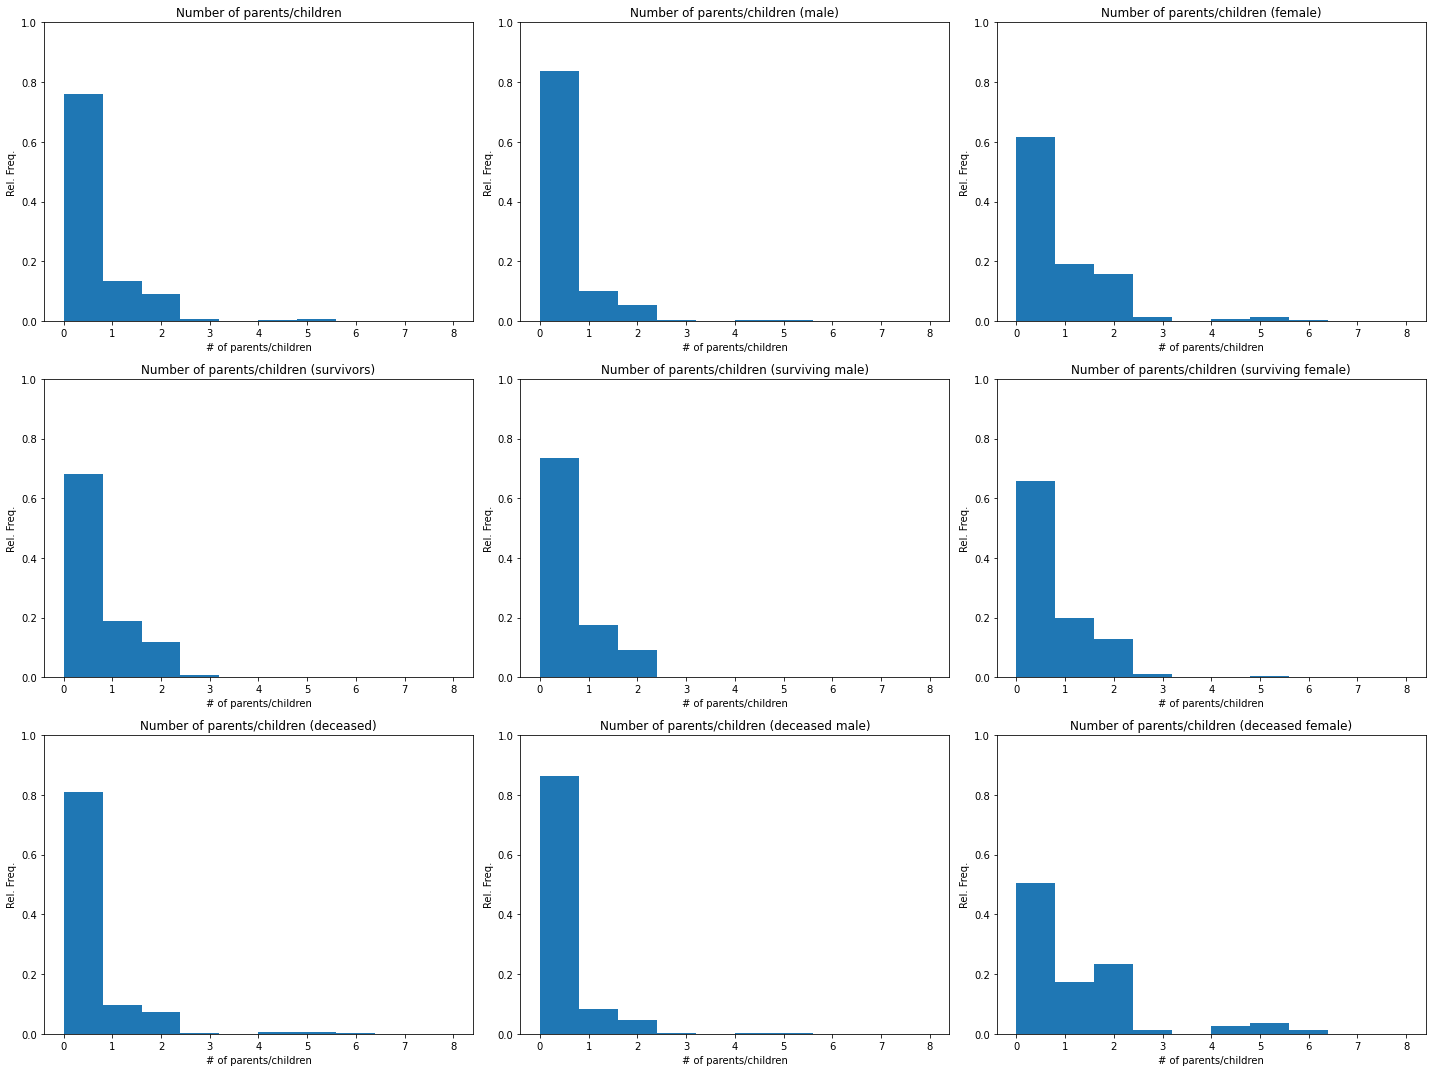

In [152]:
def plot_parch_hist(ax, data):
    x = np.linspace(0, 8, num=11)
    ax.hist(data, bins=x, weights=np.zeros_like(data) + 1. / data.size)
    ax.set_ylim(0, 1)
    ax.set_xlabel('# of parents/children')
    ax.set_ylabel('Rel. Freq.')

total_parch = train_data['Parch']
male_parch = total_parch[train_data['Sex'] == 'male']
female_parch = total_parch[train_data['Sex'] == 'female']

fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Plots of all passengers
plot_parch_hist(ax[0, 0], total_parch)
ax[0, 0].set_title("Number of parents/children")

plot_parch_hist(ax[0, 1], male_parch)
ax[0, 1].set_title("Number of parents/children (male)")

plot_parch_hist(ax[0, 2], female_parch)
ax[0, 2].set_title("Number of parents/children (female)")

# Plots of survivors
surviving_total_parch = train_data[train_data['Survived'] == 1]['Parch']
surviving_male_parch = surviving_total_parch[train_data['Sex'] == 'male']
surviving_female_parch = surviving_total_parch[train_data['Sex'] == 'female']

plot_parch_hist(ax[1, 0], surviving_total_parch)
ax[1, 0].set_title("Number of parents/children (survivors)")

plot_parch_hist(ax[1, 1], surviving_male_parch)
ax[1, 1].set_title("Number of parents/children (surviving male)")

plot_parch_hist(ax[1, 2], surviving_female_parch)
ax[1, 2].set_title("Number of parents/children (surviving female)")

# Plots of deceased
deceased_total_parch = train_data[train_data['Survived'] == 0]['Parch']
deceased_male_parch = deceased_total_parch[train_data['Sex'] == 'male']
deceased_female_parch = deceased_total_parch[train_data['Sex'] == 'female']

plot_parch_hist(ax[2, 0], deceased_total_parch)
ax[2, 0].set_title("Number of parents/children (deceased)")

plot_parch_hist(ax[2, 1], deceased_male_parch)
ax[2, 1].set_title("Number of parents/children (deceased male)")

plot_parch_hist(ax[2, 2], deceased_female_parch)
ax[2, 2].set_title("Number of parents/children (deceased female)")

plt.tight_layout()

From the above plots, it appears that for both genders having at most 2 parents/children is correlated with an increased probability of survival. However, having 4 or more children/parents seems to have the opposite effect, since all individuals with 4 or more are deceased. 

For males, this pattern is repeated. This contradicts the proposed hypothesis that having parents/children will reduce a male's likelihood of survival. Instead, it is possible that having at most 2 parents/siblings is optimal for maximizing your survival. This result is somewhat similar to the observations made for `sibsp`, where having more siblings or a spouse increases the likelihood of survival for a man. 

For females, a higher number of parents/children appears to be correlated with a lower probability of survival

In [168]:
survived = train_data[train_data['Survived'] == 1]

C_total = train_data[train_data['Embarked'] == 'C']
S_total = train_data[train_data['Embarked'] == 'S']
Q_total = train_data[train_data['Embarked'] == 'Q']

C_survived = survived[survived['Embarked'] == 'C']
S_survived = survived[survived['Embarked'] == 'S']
Q_survived = survived[survived['Embarked'] == 'Q']

def relative_risk(E_survived, E_total):
    total = len(C_total) + len(S_total) + len(Q_total)
    num_survived = len(C_survived) + len(S_survived) + len(Q_survived)

    # P(S | E)
    prob_S_E = len(E_survived) / len(E_total)

    # P(S | not E)
    prob_S_not_E = (num_survived - len(E_survived)) / (total - len(E_total))

    # Relative risk of S for E compared to not E
    return prob_S_E / prob_S_not_E

print("Total number of C: %d" % len(C_total))
print("Total number of S: %d" % len(S_total))
print("Total number of Q: %d" % len(Q_total))

print("Relative risk of C: %f" % relative_risk(C_survived, C_total))
print("Relative risk of S: %f" % relative_risk(S_survived, S_total))
print("Relative risk of Q: %f" % relative_risk(Q_survived, Q_total))

Total number of C: 168
Total number of S: 644
Total number of Q: 77
Relative risk of C: 1.615891
Relative risk of S: 0.671174
Relative risk of Q: 1.020528


The proportion of survivors from Southampton, England is 0.67x less than all other passengers.

The proportion of survivors from Cherbourg, France is 1.62x than all other passengers.  

The results above suggests that the proportion of passengers who come from Queenstown (Cobh), Ireland that survived is 1.02x greater than the proportion of all other passengers. 

Thus, the point of embarkation appears to influence the likelihood of survival. 

Number of observations without a ticket: 0


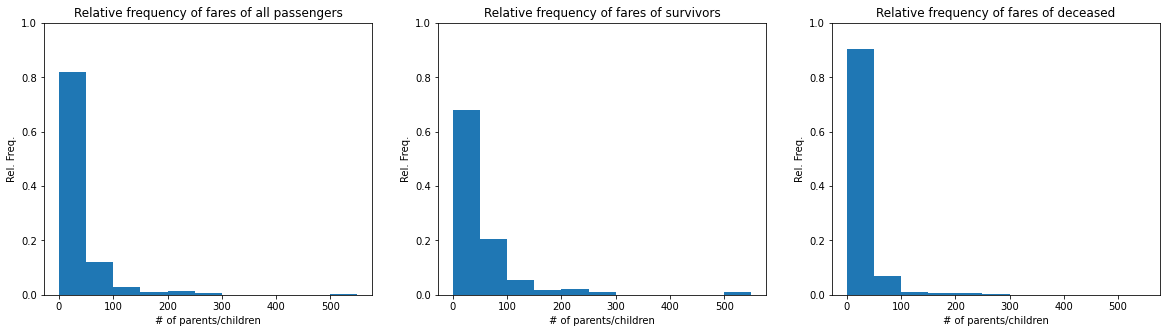

In [180]:
def plot_fare_hist(ax, data):
    x = np.linspace(0, 550, num=12)
    ax.hist(data, bins=x, weights=np.zeros_like(data) + 1. / data.size)
    ax.set_ylim(0, 1)
    ax.set_xlabel('# of parents/children')
    ax.set_ylabel('Rel. Freq.')

fare = train_data['Fare']
survivors_fare = fare[train_data['Survived'] == 1]
deceased_fare = fare[train_data['Survived'] == 0]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plots of all passengers
plot_fare_hist(ax[0], fare)
ax[0].set_title("Relative frequency of fares of all passengers")

plot_fare_hist(ax[1], survivors_fare)
ax[1].set_title("Relative frequency of fares of survivors")

plot_fare_hist(ax[2], deceased_fare)
ax[2].set_title("Relative frequency of fares of deceased")

# QUESTION: Do the observations consist only of passengers or does it also include the crew?
print("Number of observations without a ticket: %d" % train_data['Ticket'].isnull().sum())

The results indicate that all observations in this dataset likely correspond to passsengers, not sailors. This is shown by the fact that every observation has a `Ticket` number. This indicates that we can, in fact, use the `fare` as a proxy for the `cabin` and `pclass` as an indicator of the passenger's wealth.

The data indicates that a larger proportion of the survivors had ticket fares of 50 or higher. Therefore, those that paid less than 50 or those passengers that paid nothing at all made up a high proportion of the deceased. 

Note, the fact that all observations belong to passengers and not sailors invalidates a previous hypothesis in the analysis of survival frequency against age. It was found that males age `[25, 30)` make up an unusually high proportion of the survivors. This was previously suggested to be sailors who needed to be on the lifeboats. However, the observations only pertain to passengers, so the abnormally high frequency of male survivors in ages `[25, 30)` is still unexplained.

In [ ]:
## Extracting target and features

In [9]:
# Extracting the prediction target
y = train_data.Survived

# Extracting the features
X = train_data.drop(['Survived'], axis=1)

X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature selection

In [11]:
# Determine the missing columns
missing_cols = [cname for cname in X.columns if
                X[cname].isnull().any()]
missing_cols

['Age', 'Cabin', 'Embarked']

In [21]:
# Determine the number of missing entries
for cname in missing_cols:
    total = len(X[cname])
    missing = X[cname].isnull().sum()
    perc = missing / total
    print(f"{cname}: {missing} / {total} = {perc:3f}")

Age: 177 / 891 = 0.198653
Cabin: 687 / 891 = 0.771044
Embarked: 2 / 891 = 0.002245


Based on the above results, we should drop the "Cabin" column, as 77% of the values are missing and attempting to impute the missing values based on 23% of the test data might be inaccurate. 



## Preprocessing

In [ ]:
# Separating categorical and numerical columns

In [ ]:
# Determining how to handle categorical columnms
# - Can missing values be imputed based on `most-frequent` strategy? How many missing values are there? Would we be extrapolating from a small dataset to a larger one?
# - How many classes does the categorical column have? Should we use one-hot strategy?

In [ ]:
# Determining how to handle numerical columns